## 3. CRISP-DM: Data Understanding

In [5]:

# imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from IPython.display import display
import re
import os
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from IPython.display import display, Markdown
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import geodesic

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import PolynomialFeatures, StandardScaler


from imblearn.over_sampling import SMOTE 
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, confusion_matrix, recall_score, precision_score, roc_curve, f1_score

%matplotlib inline
%config InlineBackend.figure_format = 'retina' # Render high resolution images

# Load datasets
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
weather = pd.read_csv('../data/weather.csv')
spray = pd.read_csv('../data/spray.csv')


### 3.1 Data Description

### 3.2 Attribute Understanding

### 3.3 Data Quality

### 3.4 Data Visualization

##### Abhängigkeit der WNV-Präsenz von Moskitoanzahl und Temperatur

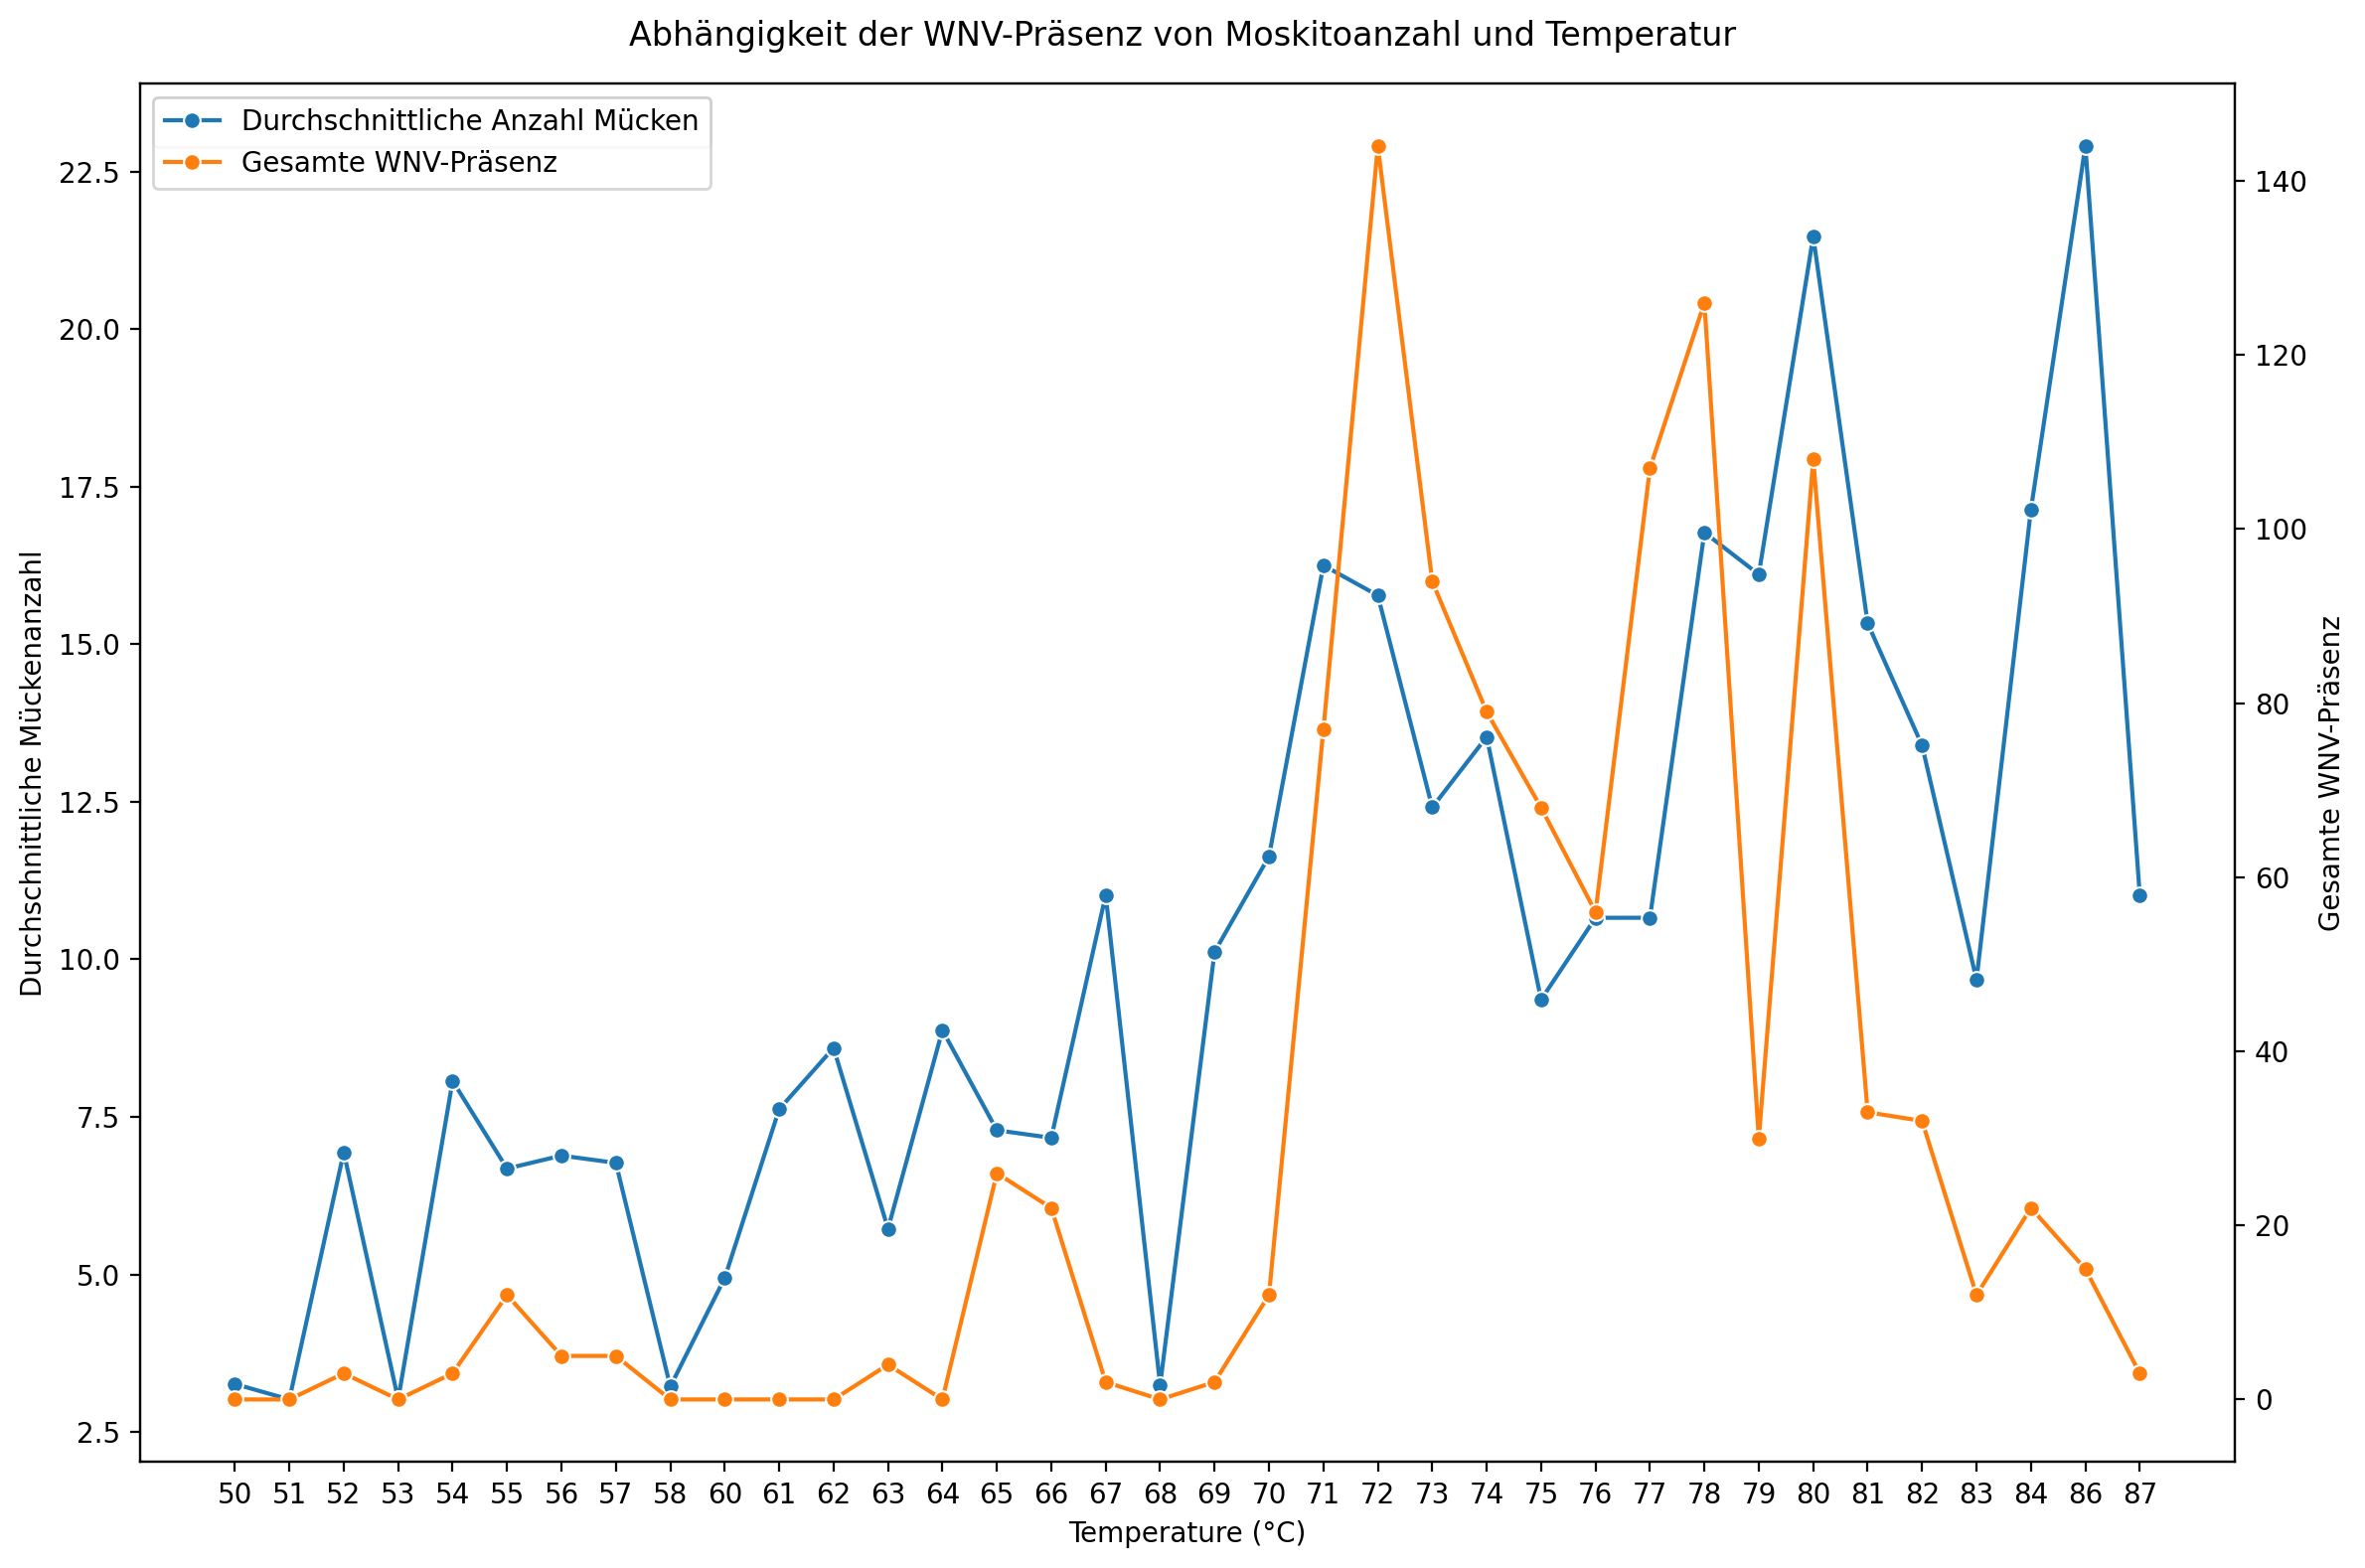

In [25]:
# Dateien einlesen
mosquito_data_path = '../data/train.csv'
weather_data_path = '../data/weather.csv'

# Dataframe erstellen
mosquito_df = pd.read_csv(mosquito_data_path)
weather_df = pd.read_csv(weather_data_path)

# Konvertieren von 'Date' in Datetime-Format
mosquito_df['Date'] = pd.to_datetime(mosquito_df['Date'], format='%Y-%m-%d')
weather_df['Date'] = pd.to_datetime(weather_df['Date'])

if 'Tavg' in weather_df.columns:
    weather_df['Temp'] = weather_df['Tavg']
else:
    # Durchschnittstemperatur berechnen (falls Min/Max-Temperatur vorhanden)
    if 'Tmax' in weather_df.columns and 'Tmin' in weather_df.columns:
        weather_df['Temp'] = (weather_df['Tmax'] + weather_df['Tmin']) / 2
    else:
        raise ValueError("Keine Temperaturdaten gefunden")

# Merge Datensätze auf Basis des Datums
merged_df = pd.merge(mosquito_df, weather_df[['Date', 'Temp']], on='Date')

# Konvertieren von 'NumMosquitos' in Integer
merged_df['NumMosquitos'] = merged_df['NumMosquitos'].astype(int)

# Berechnen des Durchschnitts der Anzahl der Mücken und der WnvPresence für jede Temperatur
avg_values_per_temp = merged_df.groupby('Temp').agg({'NumMosquitos': 'mean', 'WnvPresent': 'sum'}).reset_index()

# Plot erstellen
fig, ax1 = plt.subplots(figsize=(12, 8))

# Durchschnitt Mückenanzahl
color = 'tab:blue'
ax1.set_xlabel('Temperature (°C)')
ax1.set_ylabel('Durchschnittliche Mückenanzahl')
sns.lineplot(data=avg_values_per_temp, x='Temp', y='NumMosquitos', marker='o', ax=ax1, color=color, label='Durchschnittliche Anzahl Mücken')
ax1.tick_params(axis='y')

# Zweite Y-Achse für WnvPresence
ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Gesamte WNV-Präsenz')
sns.lineplot(data=avg_values_per_temp, x='Temp', y='WnvPresent', marker='o', ax=ax2, color=color, label='Gesamte WNV-Präsenz')
ax2.tick_params(axis='y')

# Titel 
fig.suptitle('Abhängigkeit der WNV-Präsenz von Moskitoanzahl und Temperatur')

# Legenden 
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

fig.tight_layout()
plt.show()

##### Mückenart und WNV-Präsenz

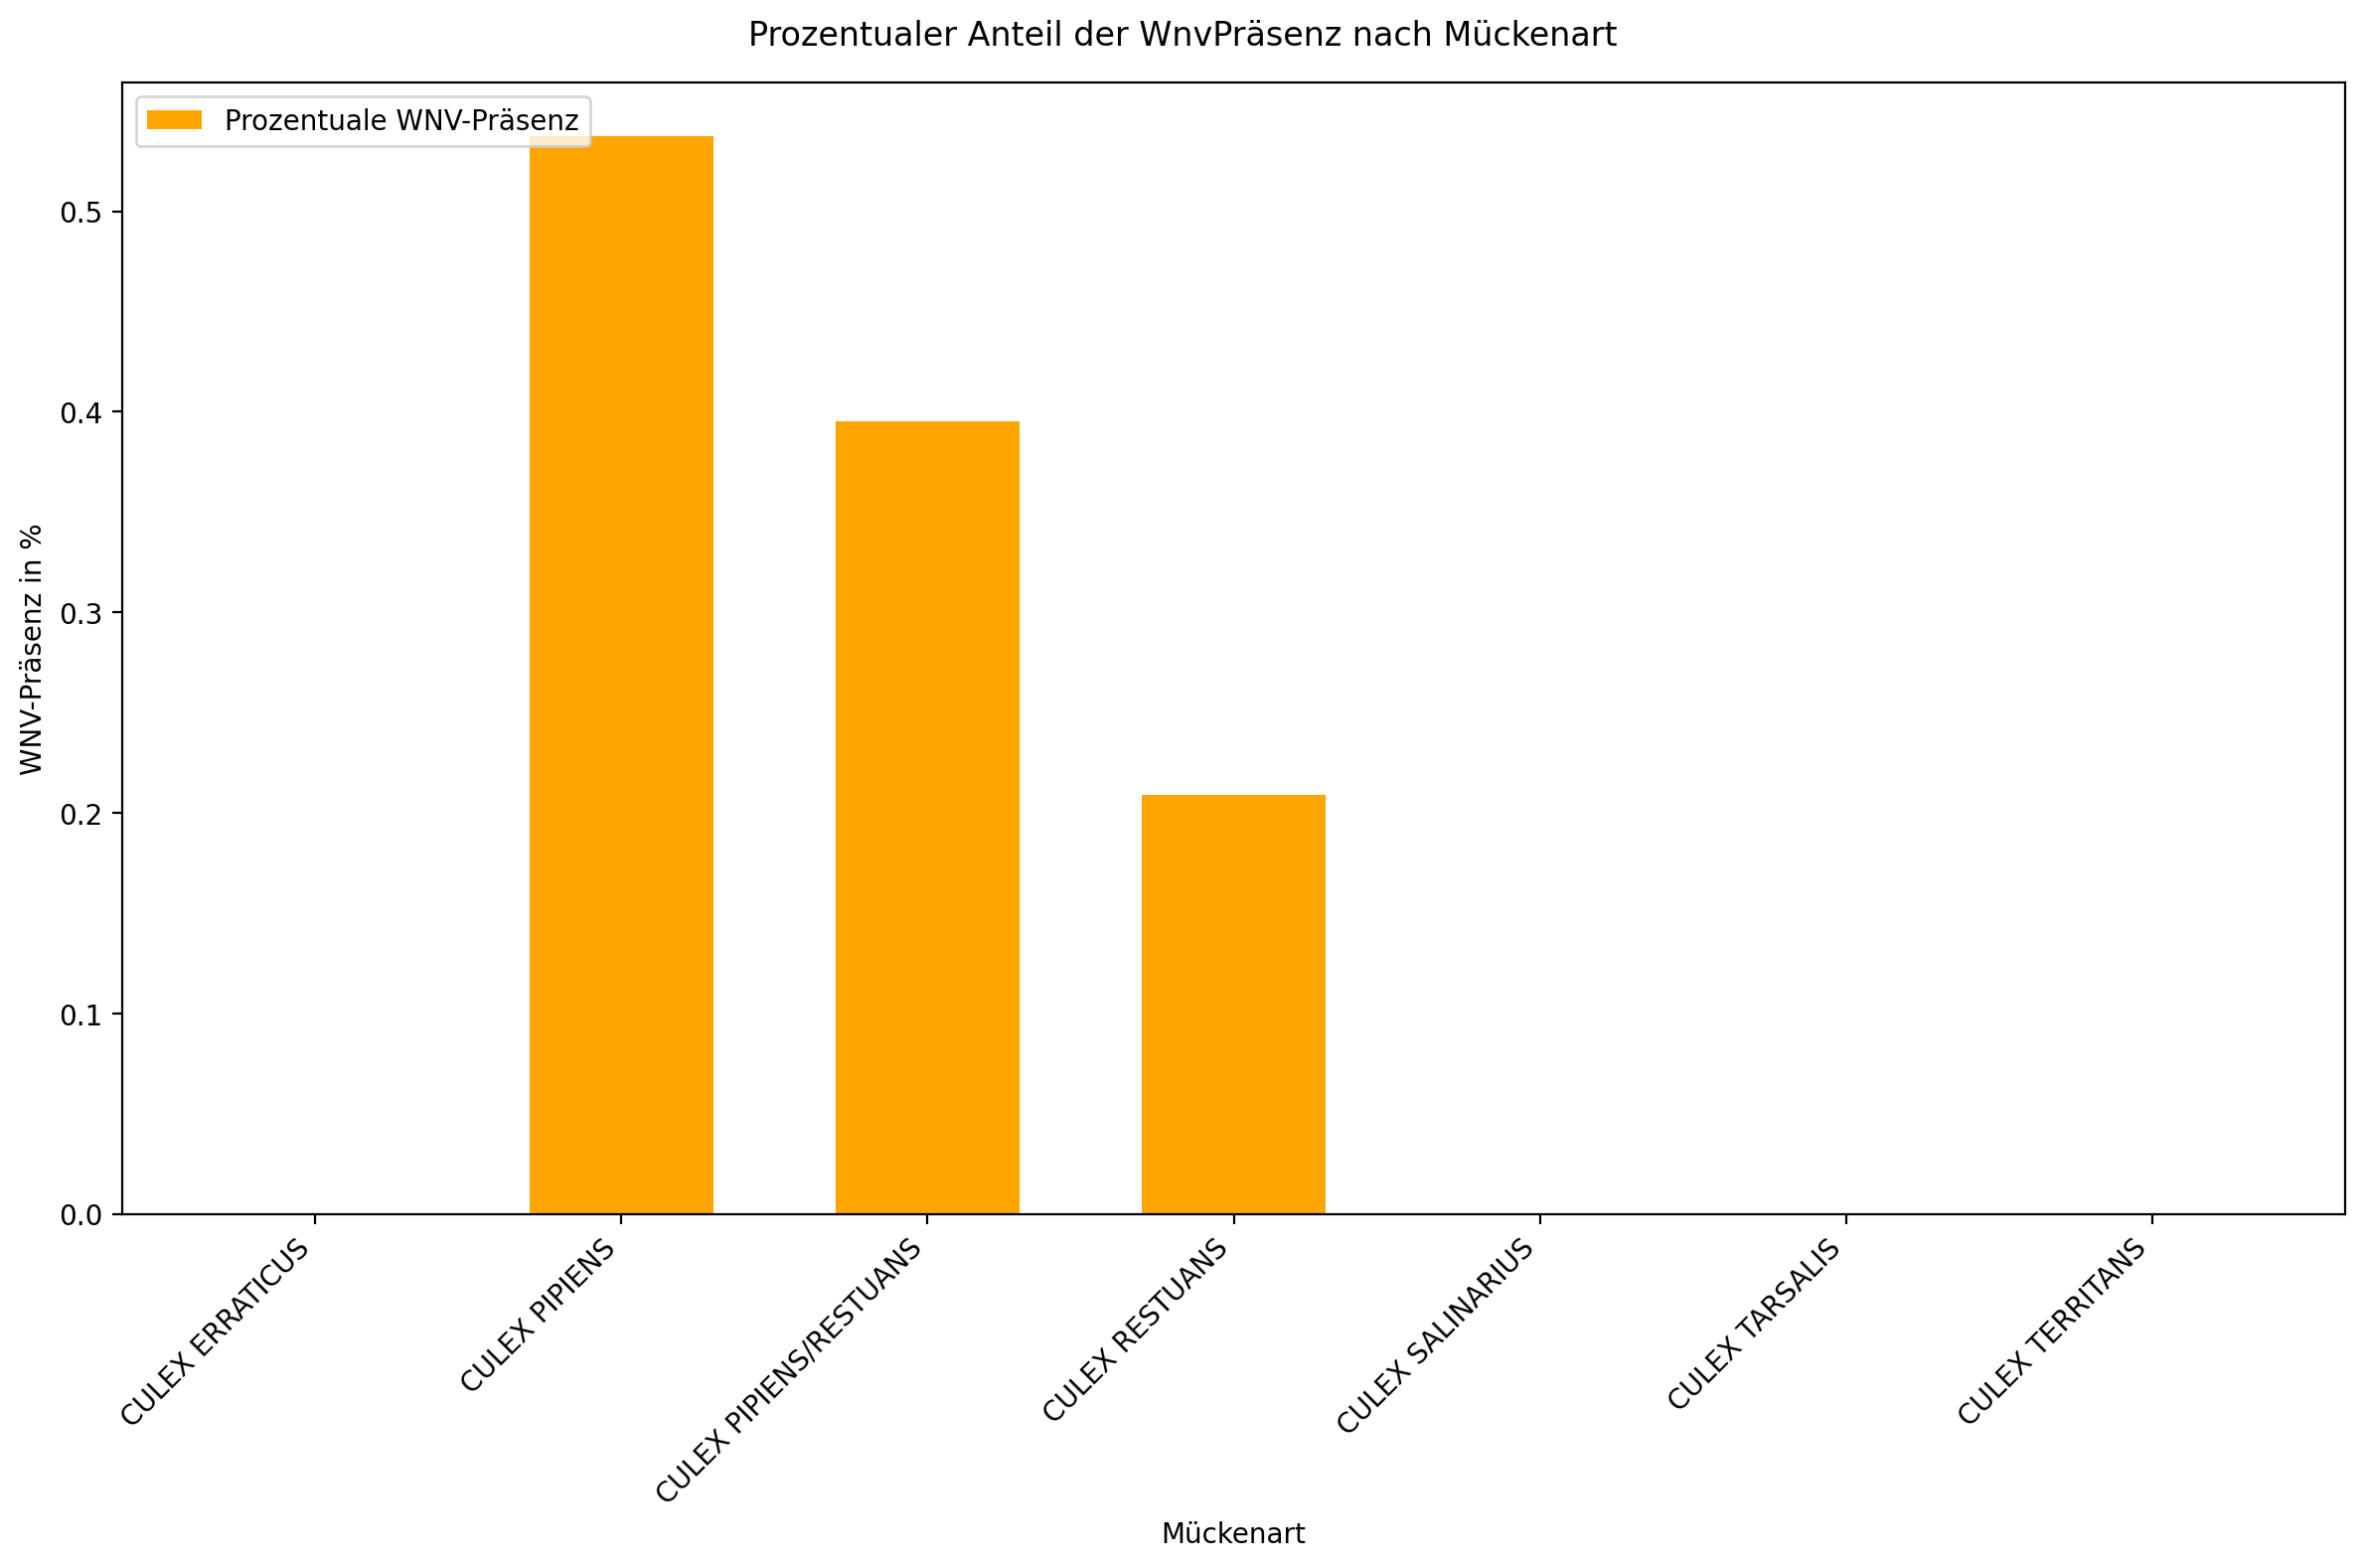

In [36]:
# Datei einlesen
file_path = '../data/train.csv'
df = pd.read_csv(file_path)

# Konvertieren von 'NumMosquitos' und 'WnvPresent' in Integer
df['NumMosquitos'] = df['NumMosquitos'].astype(int)
df['WnvPresent'] = df['WnvPresent'].astype(int)

# Gruppieren nach 'Species' und Aggregieren der Summen
species_counts = df.groupby('Species').agg({'NumMosquitos': 'sum', 'WnvPresent': 'sum'}).reset_index()

# Berechnung des prozentualen Anteils der WnvPresence pro Spezies
species_counts['WnvPresencePercentage'] = (species_counts['WnvPresent'] / species_counts['NumMosquitos']) * 100

# Balkendiagramm erstellen
fig, ax = plt.subplots(figsize=(12, 8))

bar_width = 0.6
index = np.arange(len(species_counts))

# Balken für den prozentualen Anteil der WnvPresence
bars = ax.bar(index, species_counts['WnvPresencePercentage'], bar_width, label='Prozentuale WNV-Präsenz', color='orange')
ax.set_xlabel('Mückenart')
ax.set_ylabel('WNV-Präsenz in %')
ax.tick_params(axis='y')

# Achsenbeschriftungen und Titel setzen
ax.set_xticks(index)
ax.set_xticklabels(species_counts['Species'], rotation=45, ha='right')
fig.suptitle('Prozentualer Anteil der WnvPräsenz nach Mückenart')

# Legende hinzufügen
ax.legend(loc='upper left')

fig.tight_layout()
plt.show()

##### Übersicht Vorkommen der Mückenarten

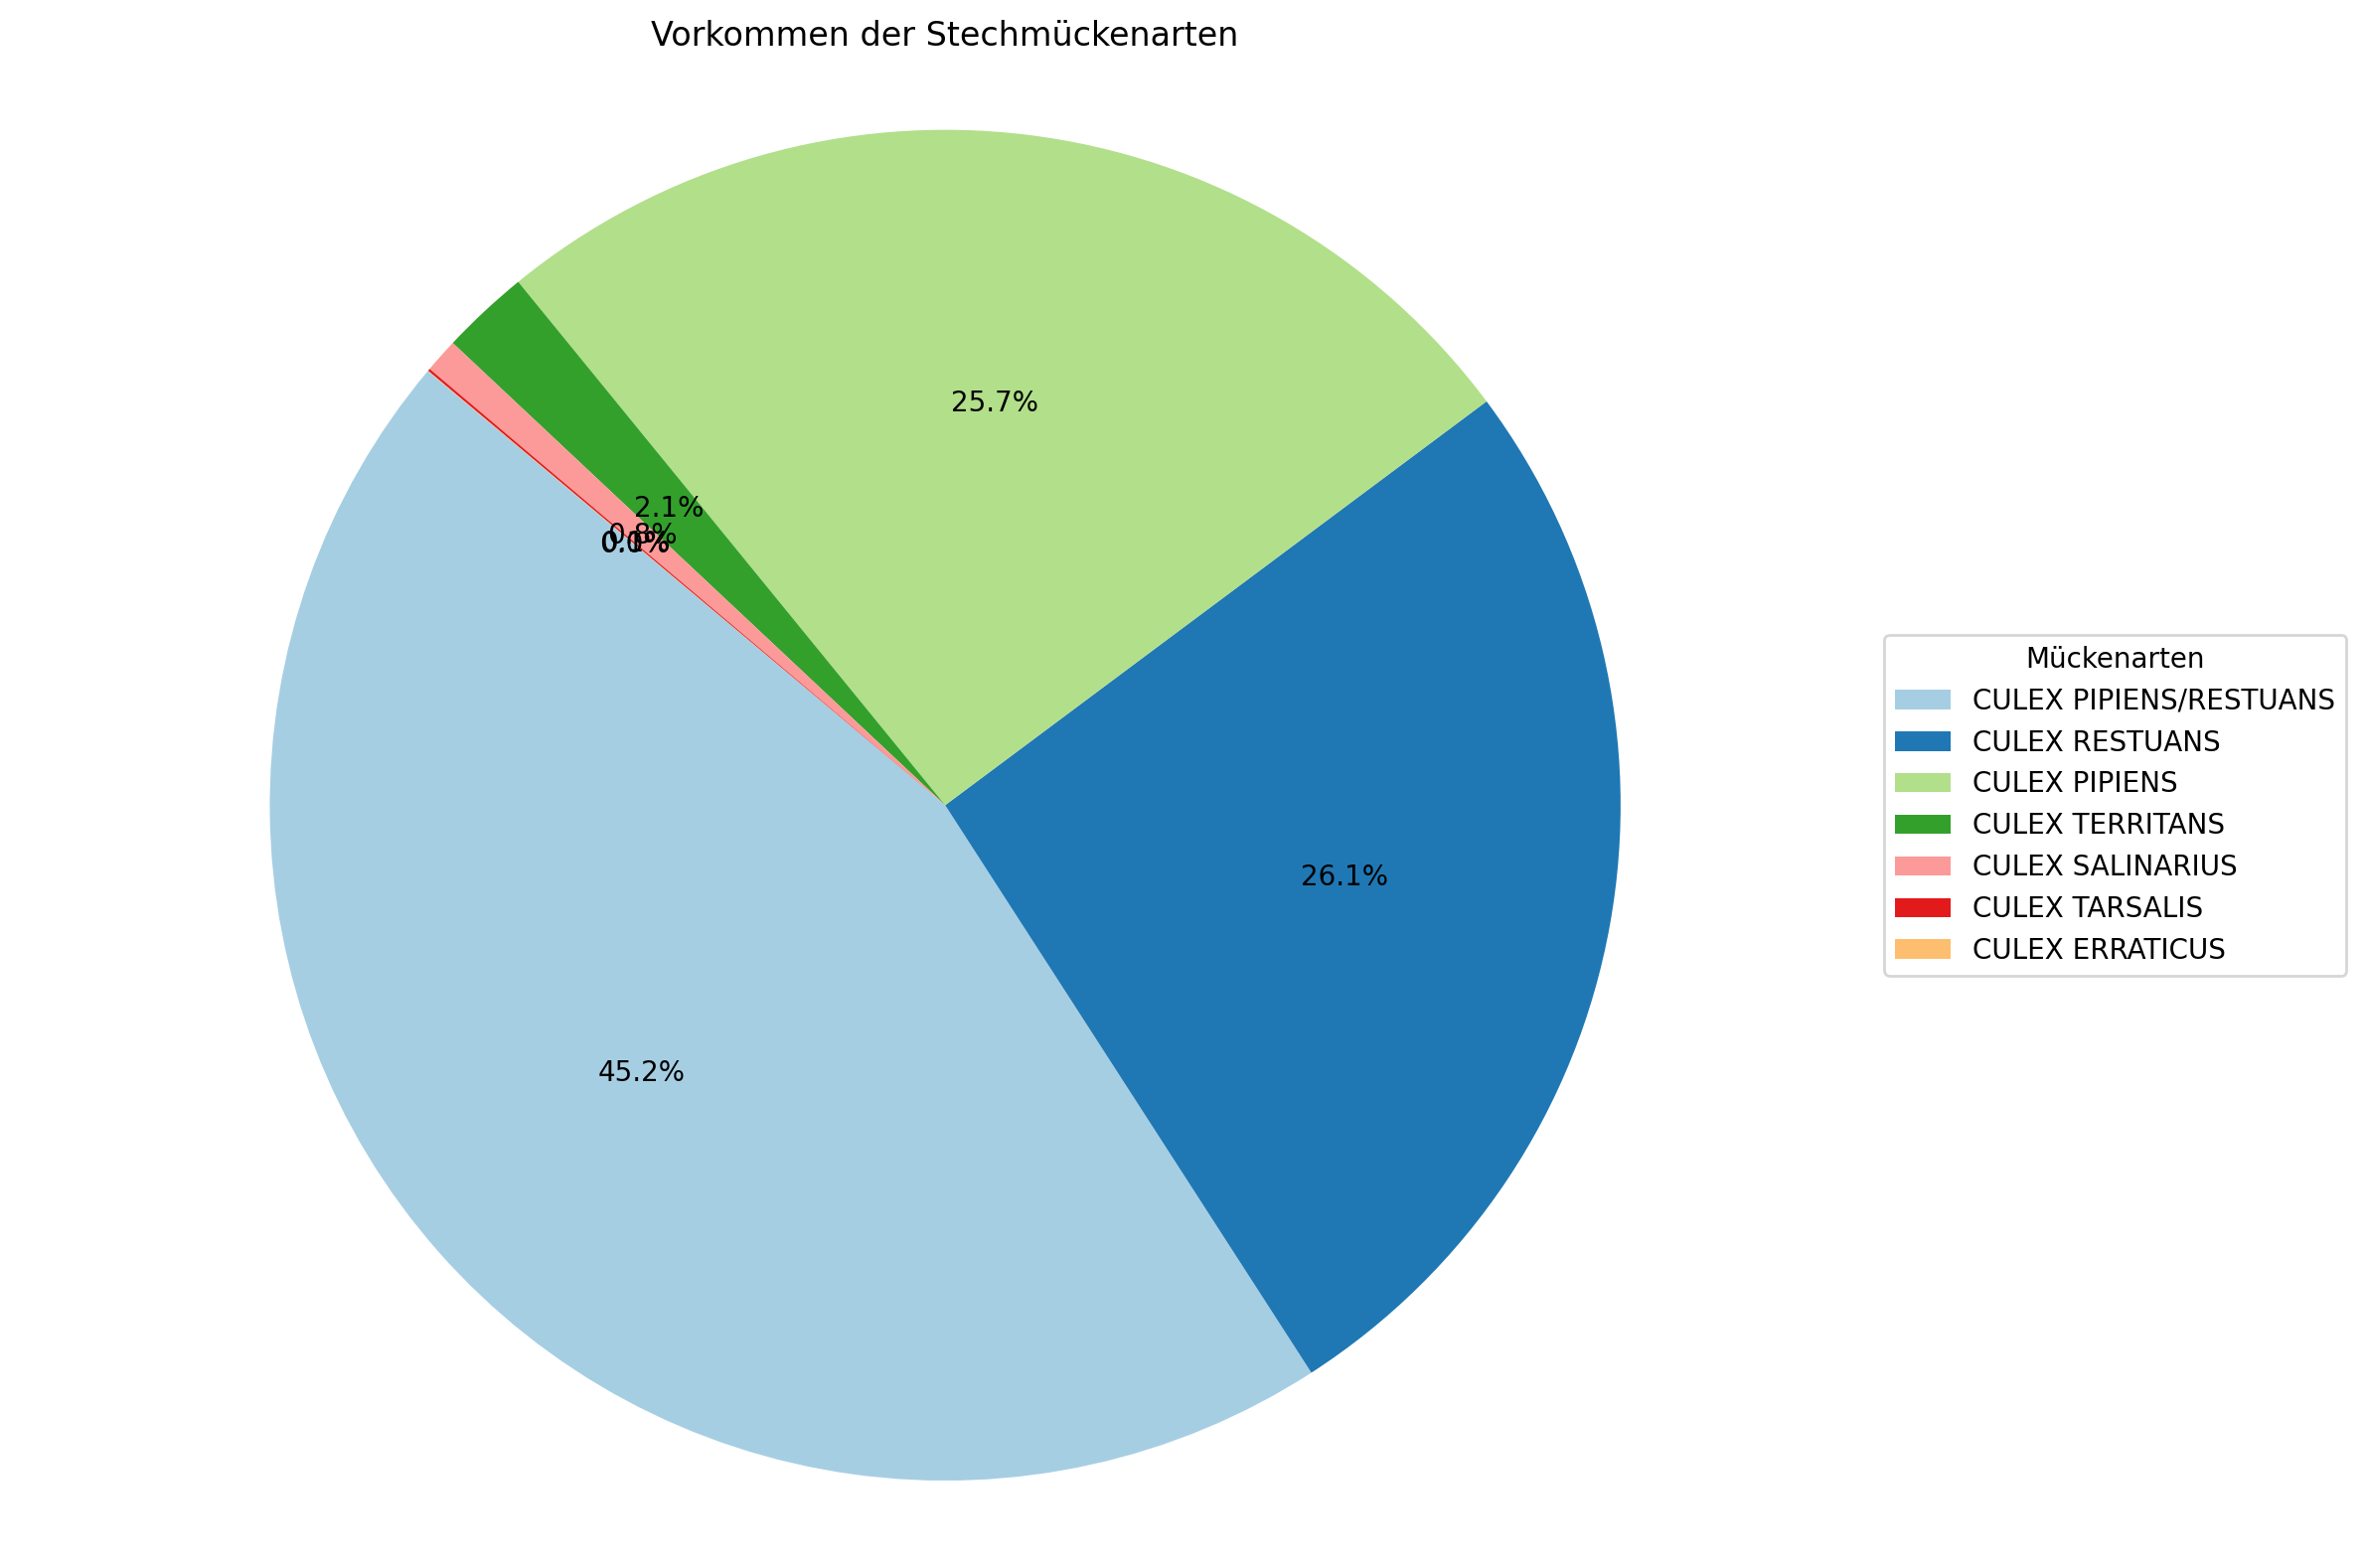

In [38]:
# Datei einlesen und Delimiter setzen
file_path = '../data/train.csv'  # Passen Sie den Pfad zur Datei an
df = pd.read_csv(file_path)

# Gruppieren nach 'Species' und Zählen der Vorkommen
species_counts = df['Species'].value_counts()

# Kuchendiagramm erstellen
plt.figure(figsize=(12, 8))
wedges, texts, autotexts = plt.pie(species_counts, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)

# Legende hinzufügen
plt.legend(wedges, species_counts.index, title='Mückenarten', loc='center left', bbox_to_anchor=(1, 0, 0.5, 1))

plt.title('Vorkommen der Stechmückenarten')
plt.axis('equal')  # Gleichmäßige Darstellung
plt.tight_layout()
plt.show()

##### Mückenanzahl über Jahre

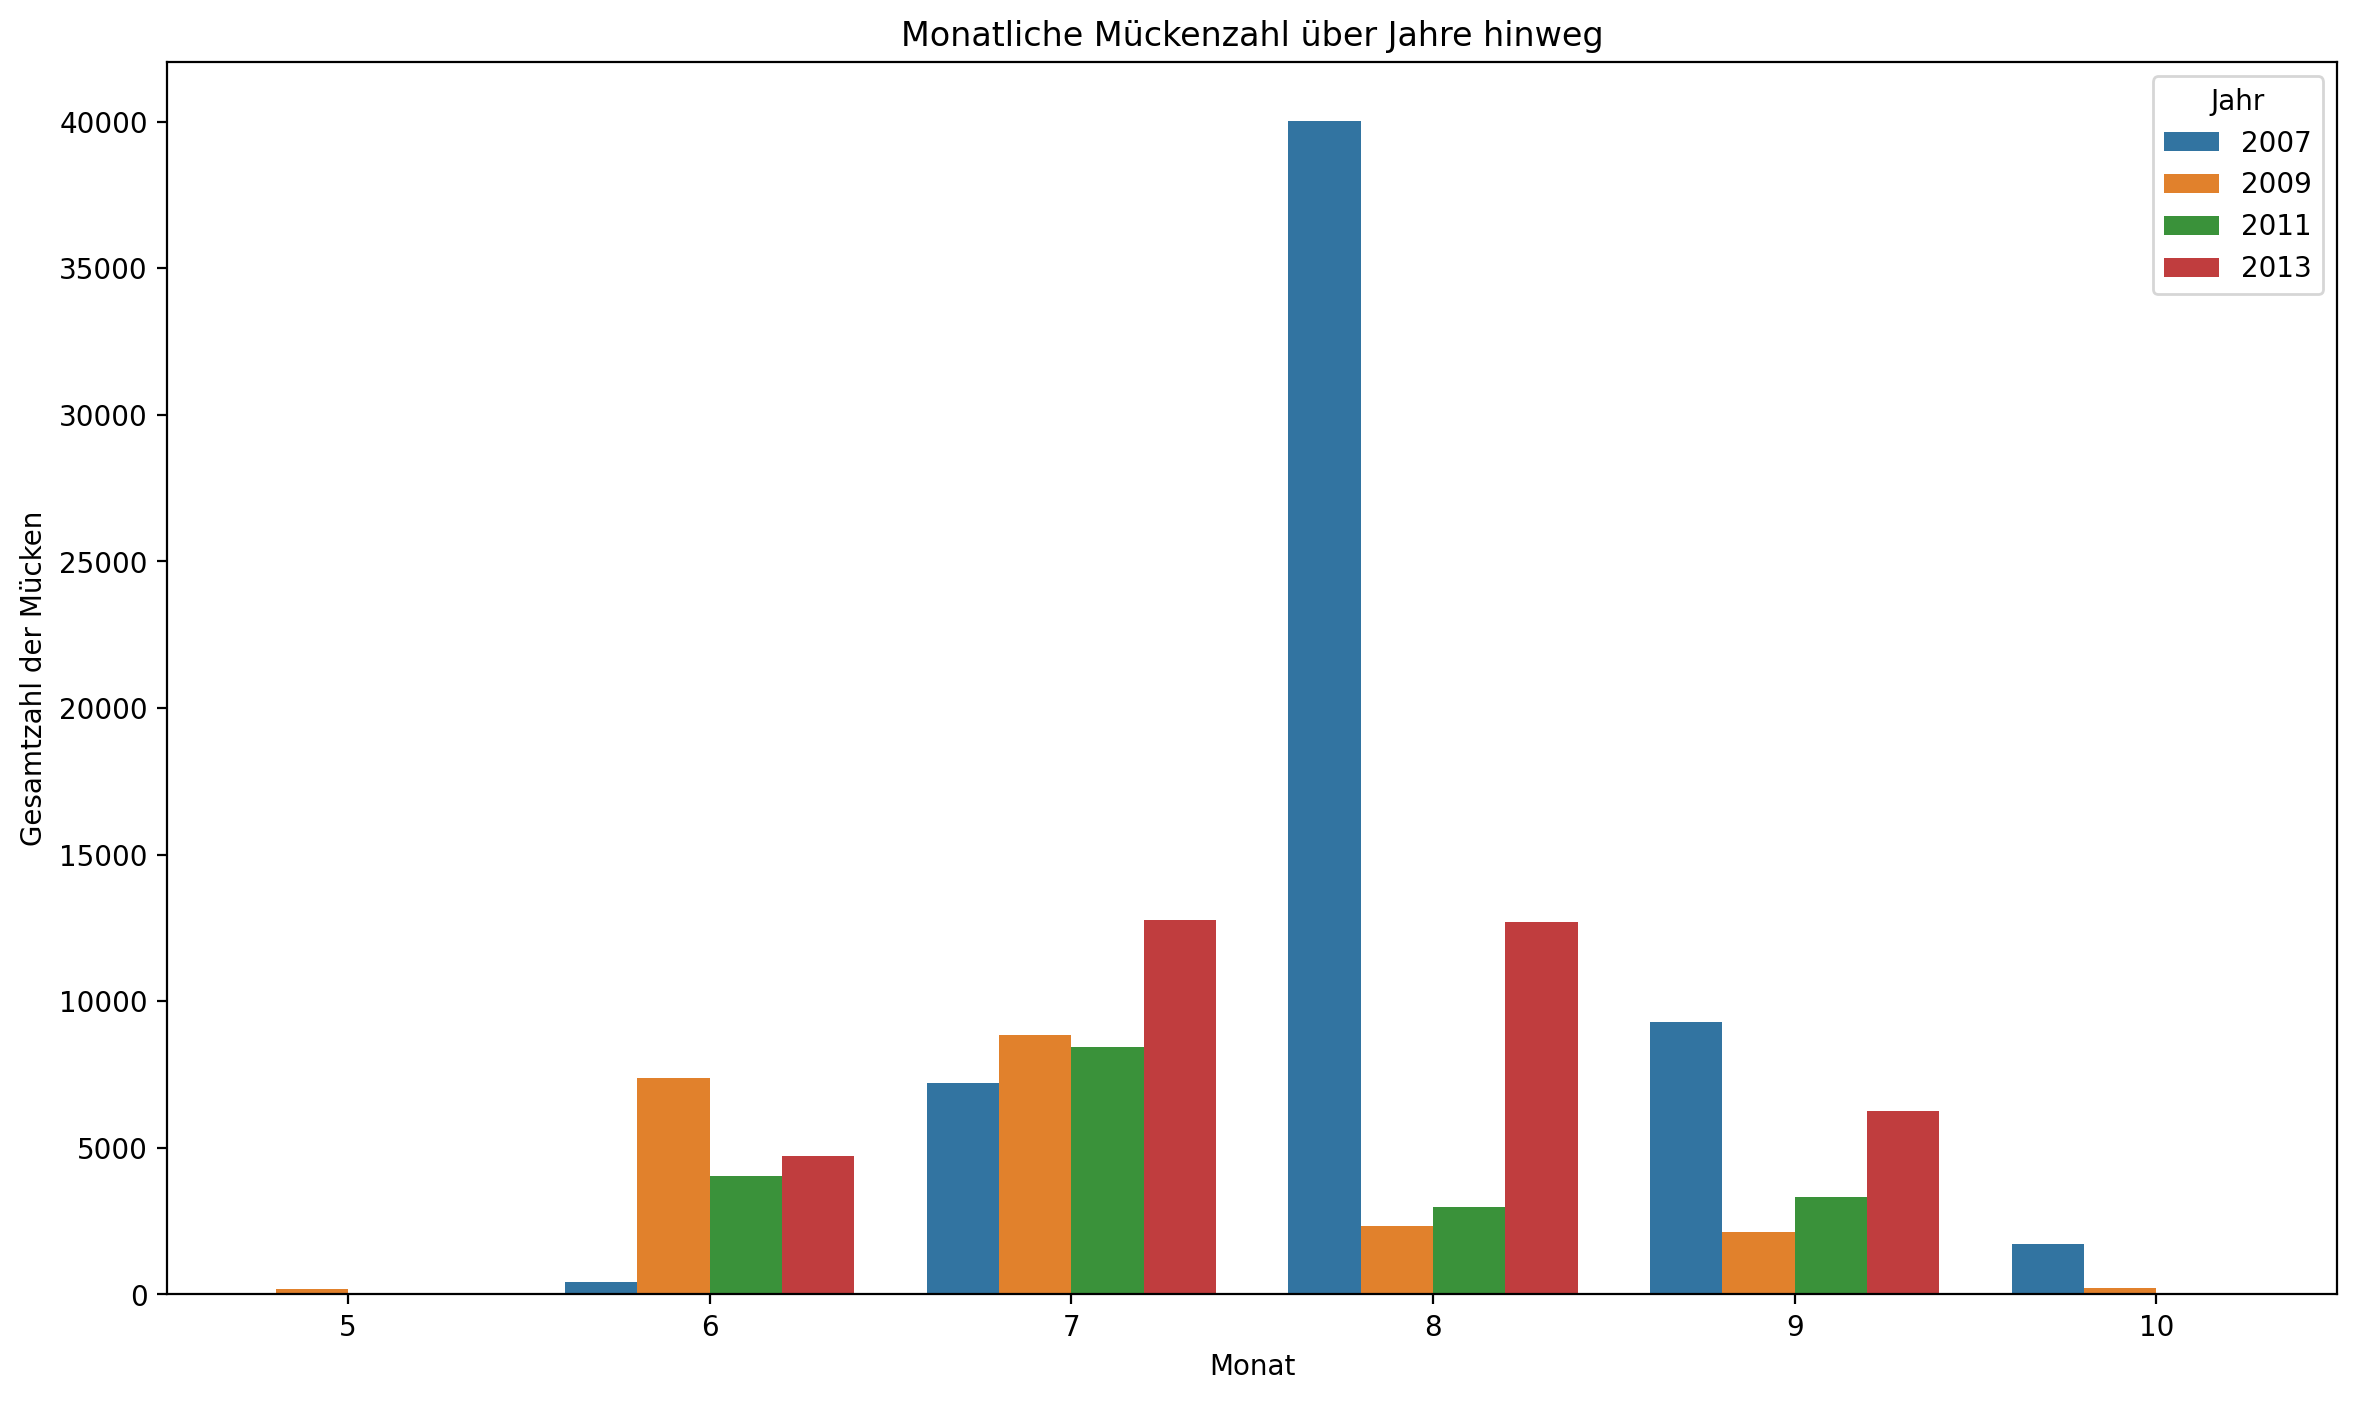

In [45]:
# Datei einlesen und Delimiter setzen
file_path = '../data/train.csv'  # Passen Sie den Pfad zur Datei an
df = pd.read_csv(file_path)

# Konvertieren der 'Date'-Spalte in Datetime-Format
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

# Extrahieren von Jahr und Monat
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

# Gruppieren nach Jahr und Monat und Summieren der Anzahl der Mücken
monthly_counts = df.groupby(['Year', 'Month']).agg({'NumMosquitos': 'sum'}).reset_index()

# Bar-Chart erstellen
plt.figure(figsize=(14, 8))
sns.barplot(x='Month', y='NumMosquitos', hue='Year', data=monthly_counts, palette='tab10')
plt.title('Monatliche Mückenzahl über Jahre hinweg')
plt.xlabel('Monat')
plt.ylabel('Gesamtzahl der Mücken')
plt.legend(title='Jahr')
plt.show()

##### WNV-Präsenz über Jahre

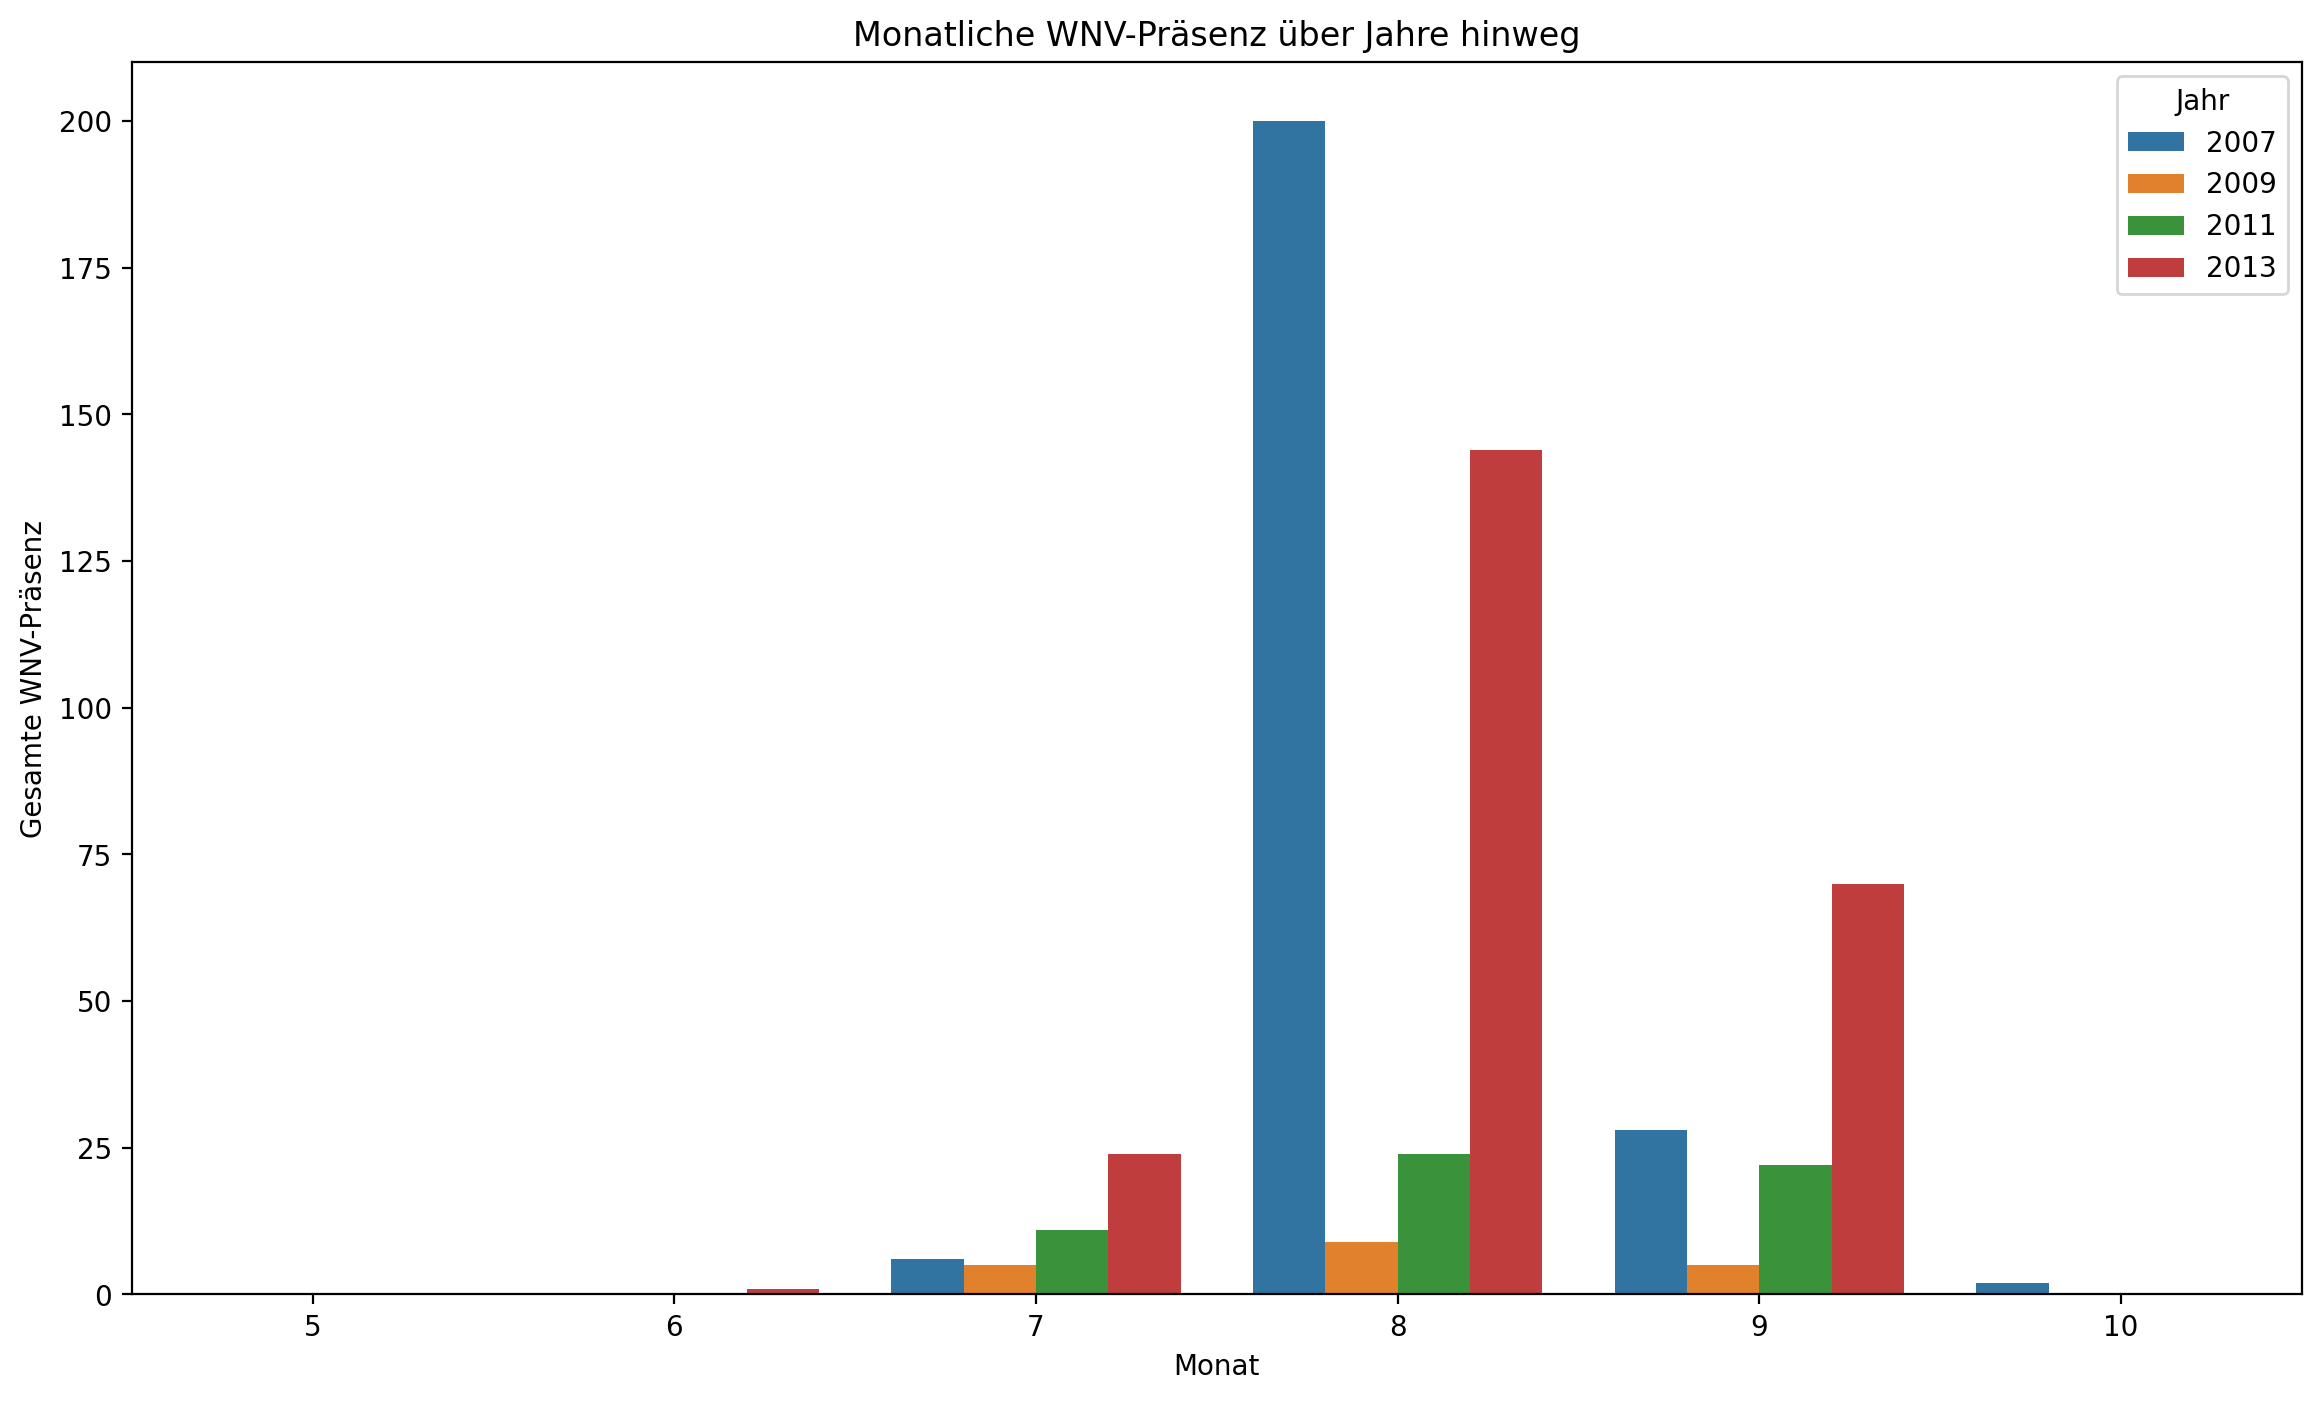

In [44]:
# Datei einlesen und Delimiter setzen
file_path = '../data/train.csv'
df = pd.read_csv(file_path)

# Konvertieren der 'Date'-Spalte in Datetime-Format
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

# Extrahieren von Jahr und Monat
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

# Gruppieren nach Jahr und Monat und Summieren der Anzahl der WnvPresence
monthly_wnv_counts = df.groupby(['Year', 'Month']).agg({'WnvPresent': 'sum'}).reset_index()

# Bar-Chart erstellen
plt.figure(figsize=(14, 8))
sns.barplot(x='Month', y='WnvPresent', hue='Year', data=monthly_wnv_counts, palette='tab10')
plt.title('Monatliche WNV-Präsenz über Jahre hinweg')
plt.xlabel('Monat')
plt.ylabel('Gesamte WNV-Präsenz')
plt.legend(title='Jahr')
plt.show()

TODO: Korrelationsmatrix --> hatte ich probiert, kam dann leider nicht weiter, wie ich damit umgehen kann, dass die Daten, die ich für die Korrelation vergleichen will, nicht aus der gleichen File kommen. Muss mir das daher nochmal anschauen

- `train.csv` und `test.csv`: Training und Testdatensätze.

- `weather.csv`: Wetterdaten von 2007 bis 2014.

- `spray.csv`: GIS-Daten von Sprühaktionen in 2011 und 2013.


- `Date`: Datum des Tests.

- `Species`: Mückenart.

- `Trap`: ID der Falle.

- `NumMosquitos`: Anzahl der gefangenen Mücken.

- `WnvPresent`: WNV vorhanden (1: Ja, 0: Nein).

- `Latitude` und `Longitude`: Geografische Koordinaten.